### Import packages

In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import numpy as np
import seaborn as sns
import json
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

%matplotlib inline

### Read in zips GeoDataFrame

In [2]:
zips = gpd.read_file('../data/zipcodes.geojson')
print(zips.crs)
zips.head( )

epsg:4326


,zip,objectid,po_name,shape_stlength,shape_starea,geometry
0,37115,1,MADISON,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ..."
1,37216,3,NASHVILLE,75820.997821400058,188884682.28344727,"MULTIPOLYGON (((-86.73451 36.23774, -86.73425 ..."
2,37204,9,NASHVILLE,93180.292250425613,200664795.51708984,"MULTIPOLYGON (((-86.77914 36.13424, -86.77923 ..."
3,37027,11,BRENTWOOD,159760.6942933173,174978422.04101562,"MULTIPOLYGON (((-86.81258 36.06319, -86.81263 ..."
4,37064,18,FRANKLIN,28995.828320601937,46969608.005737305,"MULTIPOLYGON (((-87.02197 36.01200, -87.02140 ..."


### Read in zips_census data, clean it, and create GeoDataFrame

In [3]:
#read in zips census data
zips_census = pd.read_csv('../data/zip_census.csv')

#split location column on comma
split_location = zips_census.Location.str.split(pat = ",", 
                                                expand = True)
#assign split_location to new columns in zips_census
zips_census["latitude"] = split_location[0]
zips_census["longitude"] = split_location[1]

#drop Location column
zips_census = zips_census.drop(columns = ["Location"])

#convert new latitude and longitude columns to floats
zips_census.latitude = zips_census.latitude.astype(float)
zips_census.longitude = zips_census.longitude.astype(float)

#create geometry column from latitude and longitude
zips_census["geometry"] = zips_census.apply(lambda x: Point(x.longitude, x.latitude), 
                                            axis = 1)

#create zips census GeoDataFrame
zips_census_geo = gpd.GeoDataFrame(zips_census,
                                  crs = zips.crs,
                                  geometry = zips_census["geometry"])

#take a peek
print(zips_census_geo)
zips_census_geo.info()

    Zip Code Population People / Sq. Mile   latitude  longitude  \
0      37212     18,547          6,556.46  36.133973 -86.801471   
1      37201      1,167          3,602.97  36.165550 -86.777679   
2      37206     27,751          3,597.99  36.180771 -86.730153   
3      37208     15,272          3,416.62  36.178567 -86.805263   
4      37219        830          3,259.85  36.166457 -86.782946   
5      37211     64,753          3,030.86  36.066734 -86.722609   
6      37203     12,781          3,025.69  36.149926 -86.789227   
7      37216     19,132          2,791.23  36.216583 -86.726843   
8      37210     16,170          1,747.70  36.149265 -86.732957   
9      37207     35,744          1,712.06  36.238944 -86.779883   
10     37204     11,024          1,491.97  36.106277 -86.773949   
11     37217     28,293          1,488.46  36.113155 -86.667020   
12     37205     21,861          1,412.27  36.103877 -86.869505   
13     37215     22,112          1,382.95  36.080535 -86.83327

### Create function to rename Census Reporter GeoDataFrame columns using metadata

In [4]:
def metarename(file, metadata, tablename):
    """Given a Census Reporter file and its metadata, rename all imported DataFrame columns."""
    name_list = ["geoid", "zip"]
    
    for i in metadata["tables"][tablename]["columns"].items():
        col_name = i[1]["name"]
        col_name_error = i[1]["name"]+" error"
        name_list.append(col_name)
        name_list.append(col_name_error)
      
    name_list.append("geometry")
    file.columns = name_list
    return file

# def metarename(file, metadata):
#     """Given a file and its metadata, rename all file columns."""
#     list = []
    
#     for i in metadata["tables"]["B01001"]["columns"].items():
#         col_name = i[1]["name"]
#         col_name_error = i[1]["name"]+" error"
#         list.append(col_name)
        
#     file.columns = list
#     return file


### Read in four census-related GeoDataFrames

#### Read in and name income by zip

In [5]:
income_by_zip = gpd.read_file('../data/income/nashville_hh_incomes_by_zip.geojson')
inc_md = open('../data/income/metadata.json')
income_meta = json.load(inc_md)

# income_by_zip = income_by_zip.rename(columns = {"B19001001": "total",
#                                "B19001001, Error": "total_error",
#                                "B19001002": "less_than_$10,000",
#                                "B19001002, Error": "less_than_$10,000_error",
#                                "B19001003": "$10,000_to_$14,999",
#                                "B19001003, Error": "$10,000_to_$14,999_error",
#                                "B19001004": "$15,000_to_$19,999",
#                                "B19001004, Error": "$15,000_to_$19,999",
#                                "B19001005": "$20,000_to_$24,999",
#                                "B19001005, Error": "$20,000_to_$24,999_error",
#                                "B19001006": "25,000_to_$29,999",
#                                "B19001006, Error": "25,000_to_$29,999_error",                               
#                                "B19001007": "$30,000_to_$34,999",
#                                "B19001007, Error": "$30,000_to_$34,999_error",                                
#                                "B19001008": "35,000_to_$39,999",
#                                "B19001008, Error": "35,000_to_$39,999_error",                                
#                                "B19001009": "$40,000_to_$44,999",
#                                "B19001009, Error": "$40,000_to_$44,999_error",                                
#                                "B19001010": "45,000_to_$49,999",
#                                "B19001010, Error": "45,000_to_$49,999_error",                                
#                                "B19001011": "50,000_to_$59,999",
#                                "B19001011, Error": "50,000_to_$59,999_error",                                
#                                "B19001012": "60,000_to_$74,999",
#                                "B19001012, Error": "60,000_to_$74,999_error",                                
#                                "B19001013": "75,000_to_$99,999",
#                                "B19001013, Error": "75,000_to_$99,999_error",                                
#                                "B19001014": "100,000_to_$124,999",
#                                "B19001014, Error": "100,000_to_$124,999_error",                                
#                                "B19001015": "125,000_to_$149,999",
#                                "B19001015, Error": "125,000_to_$149,999_error",                                
#                                "B19001016": "150,000_to_$199,999",
#                                "B19001016, Error": "150,000_to_$199,999_error",                                
#                                "B19001017": "$200,000_or_more",
#                                "B19001017, Error": "$200,000_or_more_error",                                
#                                })

metarename(income_by_zip, income_meta, "B19001")
income_by_zip.info()
income_by_zip.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   geoid                       42 non-null     object  
 1   zip                         42 non-null     object  
 2   Total:                      42 non-null     float64 
 3   Total: error                42 non-null     float64 
 4   Less than $10,000           42 non-null     float64 
 5   Less than $10,000 error     42 non-null     float64 
 6   $10,000 to $14,999          42 non-null     float64 
 7   $10,000 to $14,999 error    42 non-null     float64 
 8   $15,000 to $19,999          42 non-null     float64 
 9   $15,000 to $19,999 error    42 non-null     float64 
 10  $20,000 to $24,999          42 non-null     float64 
 11  $20,000 to $24,999 error    42 non-null     float64 
 12  $25,000 to $29,999          42 non-null     float64 
 13  $25,000 to $29

,geoid,zip,Total:,Total: error,"Less than $10,000","Less than $10,000 error","$10,000 to $14,999","$10,000 to $14,999 error","$15,000 to $19,999","$15,000 to $19,999 error",...,"$75,000 to $99,999 error","$100,000 to $124,999","$100,000 to $124,999 error","$125,000 to $149,999","$125,000 to $149,999 error","$150,000 to $199,999","$150,000 to $199,999 error","$200,000 or more","$200,000 or more error",geometry
0,86000US37013,37013,35597.0,617.0,1424.0,311.0,1023.0,239.0,1197.0,263.0,...,593.0,3547.0,574.0,1703.0,368.0,1212.0,306.0,1002.0,326.0,"MULTIPOLYGON (((-86.69818 36.01613, -86.69811 ..."
1,86000US37015,37015,6673.0,279.0,421.0,164.0,256.0,101.0,115.0,60.0,...,186.0,639.0,160.0,294.0,98.0,157.0,71.0,84.0,42.0,"MULTIPOLYGON (((-87.19417 36.24633, -87.19401 ..."
2,86000US37027,37027,19950.0,382.0,460.0,166.0,173.0,94.0,246.0,97.0,...,246.0,2167.0,255.0,1688.0,201.0,2837.0,295.0,6606.0,323.0,"MULTIPOLYGON (((-86.88878 36.01290, -86.88873 ..."
3,86000US37062,37062,4040.0,188.0,119.0,53.0,122.0,54.0,138.0,71.0,...,146.0,468.0,121.0,342.0,86.0,286.0,82.0,158.0,55.0,"MULTIPOLYGON (((-87.21873 36.01775, -87.21865 ..."
4,86000US37064,37064,21640.0,472.0,771.0,259.0,302.0,127.0,623.0,192.0,...,333.0,2338.0,341.0,2265.0,353.0,2394.0,306.0,3857.0,296.0,"MULTIPOLYGON (((-86.80060 35.90378, -86.80060 ..."


#### Read in and name sex by age by zip

In [6]:
sex_by_age_by_zip = gpd.read_file('../data/sex_by_age/sex_by_age_by_zip.geojson')
sa_md = open('../data/sex_by_age/metadata.json')
sex_age_meta = json.load(sa_md)

metarename(sex_by_age_by_zip, sex_age_meta, "B01001")

sex_by_age_by_zip.info()
sex_by_age_by_zip.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 42 entries, 0 to 41
Columns: 101 entries, geoid to geometry
dtypes: float64(98), geometry(1), object(2)
memory usage: 33.3+ KB


,geoid,zip,Total:,Total: error,Male:,Male: error,Under 5 years,Under 5 years error,5 to 9 years,5 to 9 years error,...,67 to 69 years error,70 to 74 years,70 to 74 years error,75 to 79 years,75 to 79 years error,80 to 84 years,80 to 84 years error,85 years and over,85 years and over error,geometry
0,86000US37013,37013,97939.0,2456.0,47658.0,1617.0,4550.0,514.0,3786.0,510.0,...,193.0,1019.0,240.0,571.0,208.0,315.0,130.0,233.0,82.0,"MULTIPOLYGON (((-86.69818 36.01613, -86.69811 ..."
1,86000US37015,37015,17665.0,734.0,9112.0,483.0,527.0,138.0,681.0,159.0,...,93.0,480.0,102.0,256.0,92.0,212.0,82.0,110.0,52.0,"MULTIPOLYGON (((-87.19417 36.24633, -87.19401 ..."
2,86000US37027,37027,56117.0,765.0,27888.0,915.0,1561.0,245.0,2093.0,283.0,...,145.0,1145.0,159.0,748.0,134.0,538.0,142.0,280.0,82.0,"MULTIPOLYGON (((-86.88878 36.01290, -86.88873 ..."
3,86000US37062,37062,12185.0,604.0,5990.0,361.0,232.0,81.0,349.0,94.0,...,63.0,197.0,54.0,217.0,92.0,106.0,50.0,50.0,26.0,"MULTIPOLYGON (((-87.21873 36.01775, -87.21865 ..."
4,86000US37064,37064,58937.0,1179.0,27951.0,724.0,1803.0,299.0,1838.0,302.0,...,122.0,1279.0,198.0,816.0,189.0,590.0,200.0,769.0,304.0,"MULTIPOLYGON (((-86.80060 35.90378, -86.80060 ..."


#### Read in and name sex by education by zip

In [7]:
sex_by_ed_by_zip = gpd.read_file('../data/sex_by_education/sex_by_education_by_zip.geojson')
se_md = open('../data/sex_by_education/metadata.json')
sex_ed_meta = json.load(se_md)

metarename(sex_by_ed_by_zip, sex_ed_meta, "B15002")

sex_by_ed_by_zip.info()
sex_by_ed_by_zip.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 73 columns):
 #   Column                                             Non-Null Count  Dtype   
---  ------                                             --------------  -----   
 0   geoid                                              118 non-null    object  
 1   zip                                                118 non-null    object  
 2   Total:                                             118 non-null    float64 
 3   Total: error                                       118 non-null    float64 
 4   Male:                                              118 non-null    float64 
 5   Male: error                                        118 non-null    float64 
 6   No schooling completed                             118 non-null    float64 
 7   No schooling completed error                       118 non-null    float64 
 8   Nursery to 4th grade                               118 non-null    float

,geoid,zip,Total:,Total: error,Male:,Male: error,No schooling completed,No schooling completed error,Nursery to 4th grade,Nursery to 4th grade error,...,Associate's degree error,Bachelor's degree,Bachelor's degree error,Master's degree,Master's degree error,Professional school degree,Professional school degree error,Doctorate degree,Doctorate degree error,geometry
0,86000US37010,37010,3247.0,429.0,1514.0,250.0,0.0,12.0,0.0,12.0,...,81.0,267.0,88.0,275.0,114.0,16.0,25.0,0.0,12.0,"MULTIPOLYGON (((-87.21906 36.55260, -87.21898 ..."
1,86000US37012,37012,1675.0,243.0,850.0,193.0,3.0,5.0,0.0,12.0,...,51.0,71.0,42.0,9.0,15.0,0.0,12.0,0.0,12.0,"MULTIPOLYGON (((-86.07449 36.07455, -86.07436 ..."
2,86000US37013,37013,62355.0,1417.0,29160.0,992.0,803.0,201.0,223.0,142.0,...,478.0,8208.0,853.0,2961.0,549.0,657.0,279.0,197.0,96.0,"MULTIPOLYGON (((-86.69818 36.01613, -86.69811 ..."
3,86000US37014,37014,2012.0,267.0,1000.0,131.0,9.0,16.0,0.0,12.0,...,43.0,340.0,119.0,103.0,57.0,15.0,23.0,14.0,22.0,"MULTIPOLYGON (((-86.56657 35.88630, -86.56633 ..."
4,86000US37015,37015,12590.0,508.0,6195.0,320.0,41.0,36.0,15.0,19.0,...,125.0,761.0,183.0,278.0,94.0,68.0,38.0,45.0,42.0,"MULTIPOLYGON (((-87.19417 36.24633, -87.19401 ..."


#### Read in and name ethnicity by race by zip

In [8]:
# Read in GeoDataFrame from geojson
eth_by_race_by_zip = gpd.read_file('../data/ethnicity_by_race/ethnicity_by_race_by_zip.geojson')

# Read in metadata DataFrame from json using json package
er_md = open('../data/ethnicity_by_race/metadata.json')
eth_race_meta = json.load(er_md)

# Run function using table name "B03002"
metarename(eth_by_race_by_zip, eth_race_meta, "B03002")

eth_by_race_by_zip.info()
eth_by_race_by_zip.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 45 columns):
 #   Column                                                              Non-Null Count  Dtype   
---  ------                                                              --------------  -----   
 0   geoid                                                               118 non-null    object  
 1   zip                                                                 118 non-null    object  
 2   Total:                                                              118 non-null    float64 
 3   Total: error                                                        118 non-null    float64 
 4   Not Hispanic or Latino:                                             118 non-null    float64 
 5   Not Hispanic or Latino: error                                       118 non-null    float64 
 6   White alone                                                         118 non-null    float64 
 7   

,geoid,zip,Total:,Total: error,Not Hispanic or Latino:,Not Hispanic or Latino: error,White alone,White alone error,Black or African American alone,Black or African American alone error,...,Native Hawaiian and Other Pacific Islander alone error,Some other race alone,Some other race alone error,Two or more races:,Two or more races: error,Two races including Some other race,Two races including Some other race error,"Two races excluding Some other race, and three or more races","Two races excluding Some other race, and three or more races error",geometry
0,86000US37010,37010,4966.0,647.0,4803.0,638.0,4502.0,664.0,245.0,170.0,...,75.0,0.0,12.0,53.0,65.0,0.0,12.0,53.0,65.0,"MULTIPOLYGON (((-87.21906 36.55260, -87.21898 ..."
1,86000US37012,37012,2185.0,338.0,2134.0,321.0,2050.0,321.0,73.0,75.0,...,12.0,0.0,12.0,4.0,9.0,0.0,12.0,4.0,9.0,"MULTIPOLYGON (((-86.07449 36.07455, -86.07436 ..."
2,86000US37013,37013,97939.0,2456.0,81131.0,2548.0,40080.0,1792.0,33280.0,2118.0,...,29.0,2464.0,757.0,608.0,315.0,357.0,221.0,251.0,222.0,"MULTIPOLYGON (((-86.69818 36.01613, -86.69811 ..."
3,86000US37014,37014,2835.0,382.0,2783.0,376.0,2682.0,374.0,18.0,28.0,...,12.0,0.0,12.0,12.0,19.0,12.0,19.0,0.0,12.0,"MULTIPOLYGON (((-86.56657 35.88630, -86.56633 ..."
4,86000US37015,37015,17665.0,734.0,16768.0,740.0,15842.0,746.0,304.0,115.0,...,19.0,221.0,114.0,39.0,39.0,37.0,39.0,2.0,4.0,"MULTIPOLYGON (((-87.19417 36.24633, -87.19401 ..."


### Read in COVID and Vaccine dataframes

In [9]:
covid = pd.read_csv('../data/COVID_CountByZipPerDate_03292021.csv')
vaccine = pd.read_csv('../data/vaccine_with_protocol.csv')

In [10]:
covid = covid.rename(columns = {"Specimen Collection Date":"test_date", "Zip":"zip", "Cases":"cases"})
print(covid.head())
covid.info()

   test_date      zip  cases
0   3/6/2020  37217.0      1
1  3/10/2020  37214.0      1
2  3/11/2020  37013.0      1
3  3/11/2020  37204.0      2
4  3/11/2020  37205.0      1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8832 entries, 0 to 8831
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   test_date  8832 non-null   object 
 1   zip        8456 non-null   float64
 2   cases      8832 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 207.1+ KB


In [11]:
vaccine = vaccine.rename(columns = {"zipcode":"zip"})
print(vaccine.head())
vaccine.info()

    vacc_date      zip  count_given  dose_nbr  protocol
0  2020-12-12  37215.0          1.0       1.0  two-shot
1  2020-12-14  37205.0          1.0       2.0  two-shot
2  2020-12-14  37215.0          1.0       1.0  two-shot
3  2020-12-15  37221.0          1.0       1.0  two-shot
4  2020-12-16  37215.0          1.0       1.0  two-shot
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6694 entries, 0 to 6693
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   vacc_date    6694 non-null   object 
 1   zip          6462 non-null   float64
 2   count_given  6686 non-null   float64
 3   dose_nbr     6686 non-null   float64
 4   protocol     6694 non-null   object 
dtypes: float64(3), object(2)
memory usage: 261.6+ KB


### Convert COVID and vaccine dates to datetimes, zips to strings

In [12]:
covid.test_date = pd.to_datetime(covid.test_date)
covid.zip = covid.zip.astype(str)
covid.info()
print(covid.head())
print(set(covid.zip))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8832 entries, 0 to 8831
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   test_date  8832 non-null   datetime64[ns]
 1   zip        8832 non-null   object        
 2   cases      8832 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 207.1+ KB
   test_date      zip  cases
0 2020-03-06  37217.0      1
1 2020-03-10  37214.0      1
2 2020-03-11  37013.0      1
3 2020-03-11  37204.0      2
4 2020-03-11  37205.0      1
{'37217.0', '37204.0', '37201.0', '37210.0', '37138.0', '37221.0', '37080.0', '37205.0', '37207.0', '37213.0', '37220.0', '37214.0', '37209.0', '37115.0', '37076.0', '37212.0', '37208.0', '37206.0', '37238.0', '37069.0', '37027.0', '37228.0', '37013.0', '37203.0', '37216.0', '37211.0', 'nan', '37189.0', '37072.0', '37219.0', '37218.0', '37215.0'}


In [13]:
vaccine.vacc_date = pd.to_datetime(vaccine.vacc_date)
vaccine.zip = vaccine.zip.astype(str)
vaccine.dose_nbr = vaccine.dose_nbr.astype(str)
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6694 entries, 0 to 6693
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vacc_date    6694 non-null   datetime64[ns]
 1   zip          6694 non-null   object        
 2   count_given  6686 non-null   float64       
 3   dose_nbr     6694 non-null   object        
 4   protocol     6694 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 261.6+ KB


In [14]:
covid.zip = covid.zip.apply(lambda x: x.split(".0")[0])
covid.head()

,test_date,zip,cases
0,2020-03-06,37217,1
1,2020-03-10,37214,1
2,2020-03-11,37013,1
3,2020-03-11,37204,2
4,2020-03-11,37205,1


In [15]:
vaccine.zip = vaccine.zip.apply(lambda x: x.split(".0")[0])
vaccine.head()

,vacc_date,zip,count_given,dose_nbr,protocol
0,2020-12-12,37215,1.0,1.0,two-shot
1,2020-12-14,37205,1.0,2.0,two-shot
2,2020-12-14,37215,1.0,1.0,two-shot
3,2020-12-15,37221,1.0,1.0,two-shot
4,2020-12-16,37215,1.0,1.0,two-shot


### Begin exploring vaccine data

In [16]:
vaccine.protocol.value_counts()

two-shot    5960
one-shot     734
Name: protocol, dtype: int64

In [17]:
vaccine.groupby(["zip", "dose_nbr"], as_index = False).sum()

,zip,dose_nbr,count_given
0,37013,1.0,18465.0
1,37013,2.0,8702.0
2,37027,1.0,352.0
3,37027,2.0,154.0
4,37069,1.0,50.0
...,...,...,...
61,37228,2.0,385.0
62,37238,1.0,3.0
63,37238,2.0,2.0
64,nan,1.0,4015.0


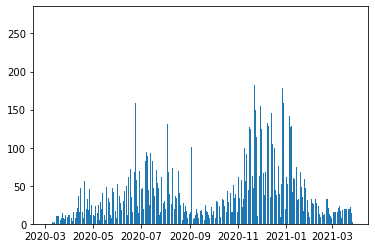

In [18]:
plt.bar("test_date","cases", data = covid)
plt.show()

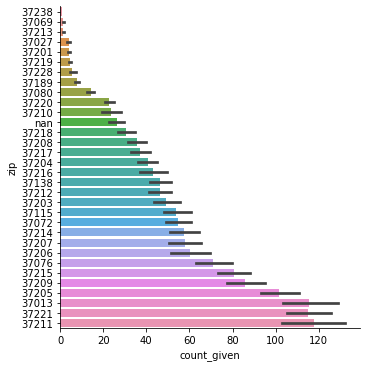

In [19]:
vaccine.zip = vaccine.zip.astype("category")
vacc_group = vaccine.groupby(["zip"], as_index = False).sum()
sns.catplot(y="zip", x="count_given", kind="bar", data=vaccine, order = vacc_group.sort_values("count_given").zip)

### Create covid_age_gdf and vaccine_age_dgf

#### Group out date columns from covid df and vaccine df

In [20]:
covid2 = covid.groupby(["zip"], as_index = False).sum()
print(covid2)

      zip  cases
0   37013  13354
1   37027    231
2   37069     16
3   37072   2984
4   37076   4279
5   37080    574
6   37115   4574
7   37138   2359
8   37189    479
9   37201    299
10  37203   3346
11  37204   1786
12  37205   2566
13  37206   3112
14  37207   4729
15  37208   2428
16  37209   5072
17  37210   2100
18  37211  10233
19  37212   1823
20  37213     65
21  37214   3508
22  37215   2438
23  37216   2011
24  37217   3907
25  37218   1785
26  37219    270
27  37220    656
28  37221   3910
29  37228    310
30  37238      3
31    nan   8412


In [21]:
vaccine2 = vaccine.groupby(["zip", "protocol", "dose_nbr"], as_index = False).sum()
vaccine2

,zip,protocol,dose_nbr,count_given
0,37013,one-shot,1.0,1240.0
1,37013,one-shot,2.0,0.0
2,37013,one-shot,nan,0.0
3,37013,two-shot,1.0,17225.0
4,37013,two-shot,2.0,8702.0
...,...,...,...,...
187,nan,one-shot,2.0,0.0
188,nan,one-shot,nan,0.0
189,nan,two-shot,1.0,3724.0
190,nan,two-shot,2.0,2063.0


#### Create a wide version of vaccine_grouped

In [22]:
vaccine2w = vaccine2.copy(deep=True)
vaccine2w = vaccine2w.pivot(index = "zip", columns = ["protocol", "dose_nbr"], values = ["count_given"])
print(vaccine2w)

         count_given                                 
protocol    one-shot           two-shot              
dose_nbr         1.0  2.0  nan      1.0      2.0  nan
zip                                                  
37013         1240.0  0.0  0.0  17225.0   8702.0  0.0
37027           31.0  0.0  0.0    321.0    154.0  0.0
37069            0.0  0.0  0.0     50.0     39.0  0.0
37072          411.0  0.0  0.0   8049.0   4648.0  0.0
37076          615.0  0.0  0.0  10498.0   5742.0  0.0
37080           54.0  0.0  0.0   1916.0   1108.0  0.0
37115          552.0  0.0  0.0   7968.0   4307.0  0.0
37138          362.0  0.0  0.0   6790.0   3721.0  0.0
37189           72.0  0.0  0.0    984.0    594.0  0.0
37201           91.0  0.0  0.0    485.0    180.0  0.0
37203          638.0  0.0  0.0   7391.0   3649.0  0.0
37204          339.0  0.0  0.0   6071.0   3313.0  0.0
37205          476.0  0.0  0.0  14190.0   9785.0  0.0
37206          898.0  0.0  0.0   9226.0   4186.0  0.0
37207          682.0  0.0  0

#### Make simpler name for sex_by_age_by_zip (saz) and relativize it to pop percentage: saz_pct

In [25]:
#rename merged 
saz = sex_by_age_by_zip
saz_pct = saz.copy(deep = True)
saz_pct.head()
saz_pct.info()

# saz_pct.apply(lambda x: x/x.loc(["Total:"]), saz_pct.iloc[:,3:len(saz_pct.columns)-1])

for i in range(3, len(saz_pct.columns)-1):
    saz_pct.iloc[:,i] = saz_pct.iloc[:,i]/saz_pct.iloc[:,2]
saz_pct.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 42 entries, 0 to 41
Columns: 101 entries, geoid to geometry
dtypes: float64(98), geometry(1), object(2)
memory usage: 33.3+ KB


,geoid,zip,Total:,Total: error,Male:,Male: error,Under 5 years,Under 5 years error,5 to 9 years,5 to 9 years error,...,67 to 69 years error,70 to 74 years,70 to 74 years error,75 to 79 years,75 to 79 years error,80 to 84 years,80 to 84 years error,85 years and over,85 years and over error,geometry
0,86000US37013,37013,97939.0,0.025077,0.486609,0.016510,0.046457,0.005248,0.038657,0.005207,...,0.001971,0.010404,0.002451,0.005830,0.002124,0.003216,0.001327,0.002379,0.000837,"MULTIPOLYGON (((-86.69818 36.01613, -86.69811 ..."
1,86000US37015,37015,17665.0,0.041551,0.515822,0.027342,0.029833,0.007812,0.038551,0.009001,...,0.005265,0.027172,0.005774,0.014492,0.005208,0.012001,0.004642,0.006227,0.002944,"MULTIPOLYGON (((-87.19417 36.24633, -87.19401 ..."
2,86000US37027,37027,56117.0,0.013632,0.496962,0.016305,0.027817,0.004366,0.037297,0.005043,...,0.002584,0.020404,0.002833,0.013329,0.002388,0.009587,0.002530,0.004990,0.001461,"MULTIPOLYGON (((-86.88878 36.01290, -86.88873 ..."
3,86000US37062,37062,12185.0,0.049569,0.491588,0.029627,0.019040,0.006648,0.028642,0.007714,...,0.005170,0.016167,0.004432,0.017809,0.007550,0.008699,0.004103,0.004103,0.002134,"MULTIPOLYGON (((-87.21873 36.01775, -87.21865 ..."
4,86000US37064,37064,58937.0,0.020004,0.474252,0.012284,0.030592,0.005073,0.031186,0.005124,...,0.002070,0.021701,0.003360,0.013845,0.003207,0.010011,0.003393,0.013048,0.005158,"MULTIPOLYGON (((-86.80060 35.90378, -86.80060 ..."


#### Merge covid2 and vaccine2 with saz_pct: saz_pct_covid and saz_pct_vacc

In [29]:
saz_pct_covid = covid2.merge(saz_pct, on = "zip", how = "left")
saz_pct_covid

,zip,cases,geoid,Total:,Total: error,Male:,Male: error,Under 5 years,Under 5 years error,5 to 9 years,...,67 to 69 years error,70 to 74 years,70 to 74 years error,75 to 79 years,75 to 79 years error,80 to 84 years,80 to 84 years error,85 years and over,85 years and over error,geometry
0,37013,13354,86000US37013,97939.0,0.025077,0.486609,0.016510,0.046457,0.005248,0.038657,...,0.001971,0.010404,0.002451,0.005830,0.002124,0.003216,0.001327,0.002379,0.000837,"MULTIPOLYGON (((-86.69818 36.01613, -86.69811 ..."
1,37027,231,86000US37027,56117.0,0.013632,0.496962,0.016305,0.027817,0.004366,0.037297,...,0.002584,0.020404,0.002833,0.013329,0.002388,0.009587,0.002530,0.004990,0.001461,"MULTIPOLYGON (((-86.88878 36.01290, -86.88873 ..."
2,37069,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,37072,2984,86000US37072,31492.0,0.024228,0.486695,0.018576,0.027975,0.006446,0.035914,...,0.004350,0.025848,0.006256,0.018925,0.004604,0.010574,0.003398,0.015178,0.003810,"MULTIPOLYGON (((-86.69587 36.43186, -86.69558 ..."
4,37076,4279,86000US37076,40161.0,0.029456,0.488036,0.019272,0.036279,0.007694,0.031697,...,0.002764,0.021165,0.003984,0.011877,0.003461,0.013047,0.003511,0.007370,0.002390,"MULTIPOLYGON (((-86.62539 36.14730, -86.62467 ..."
5,37080,574,86000US37080,7394.0,0.079389,0.500811,0.044225,0.023668,0.011225,0.014877,...,0.008791,0.018258,0.007844,0.015553,0.007844,0.008656,0.005139,0.010955,0.006086,"MULTIPOLYGON (((-87.01091 36.36218, -87.01081 ..."
6,37115,4574,86000US37115,40343.0,0.039635,0.480282,0.026200,0.036834,0.008800,0.037404,...,0.004710,0.018367,0.004734,0.010039,0.002875,0.011997,0.003198,0.011006,0.002553,"MULTIPOLYGON (((-86.75793 36.25642, -86.75792 ..."
7,37138,2359,86000US37138,23784.0,0.042129,0.475950,0.026993,0.025605,0.007148,0.020013,...,0.007190,0.018416,0.006601,0.013286,0.005508,0.009712,0.005003,0.008115,0.004625,"MULTIPOLYGON (((-86.68716 36.28444, -86.68706 ..."
8,37189,479,86000US37189,4016.0,0.114044,0.408865,0.062251,0.025896,0.015189,0.011454,...,0.010209,0.033367,0.014193,0.006723,0.006723,0.011703,0.006723,0.013446,0.015189,"MULTIPOLYGON (((-86.89144 36.26205, -86.89100 ..."
9,37201,299,86000US37201,1619.0,0.239036,0.768993,0.191476,0.000000,0.007412,0.000000,...,0.007412,0.000000,0.007412,0.000000,0.007412,0.000000,0.007412,0.000000,0.007412,"MULTIPOLYGON (((-86.78531 36.17486, -86.78501 ..."


In [26]:
saz_pct_vacc = vaccine2.merge(saz_pct, on = "zip", how = "left")
saz_pct_vacc

,zip,protocol,dose_nbr,count_given,geoid,Total:,Total: error,Male:,Male: error,Under 5 years,...,67 to 69 years error,70 to 74 years,70 to 74 years error,75 to 79 years,75 to 79 years error,80 to 84 years,80 to 84 years error,85 years and over,85 years and over error,geometry
0,37013,one-shot,1.0,1240.0,86000US37013,97939.0,0.025077,0.486609,0.016510,0.046457,...,0.001971,0.010404,0.002451,0.005830,0.002124,0.003216,0.001327,0.002379,0.000837,"MULTIPOLYGON (((-86.69818 36.01613, -86.69811 ..."
1,37013,one-shot,2.0,0.0,86000US37013,97939.0,0.025077,0.486609,0.016510,0.046457,...,0.001971,0.010404,0.002451,0.005830,0.002124,0.003216,0.001327,0.002379,0.000837,"MULTIPOLYGON (((-86.69818 36.01613, -86.69811 ..."
2,37013,one-shot,nan,0.0,86000US37013,97939.0,0.025077,0.486609,0.016510,0.046457,...,0.001971,0.010404,0.002451,0.005830,0.002124,0.003216,0.001327,0.002379,0.000837,"MULTIPOLYGON (((-86.69818 36.01613, -86.69811 ..."
3,37013,two-shot,1.0,17225.0,86000US37013,97939.0,0.025077,0.486609,0.016510,0.046457,...,0.001971,0.010404,0.002451,0.005830,0.002124,0.003216,0.001327,0.002379,0.000837,"MULTIPOLYGON (((-86.69818 36.01613, -86.69811 ..."
4,37013,two-shot,2.0,8702.0,86000US37013,97939.0,0.025077,0.486609,0.016510,0.046457,...,0.001971,0.010404,0.002451,0.005830,0.002124,0.003216,0.001327,0.002379,0.000837,"MULTIPOLYGON (((-86.69818 36.01613, -86.69811 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,37228,one-shot,2.0,0.0,86000US37228,1615.0,0.224768,0.438390,0.175851,0.000000,...,0.075542,0.019195,0.018576,0.010526,0.017957,0.013003,0.017957,0.009288,0.008669,"MULTIPOLYGON (((-86.82759 36.19146, -86.82746 ..."
170,37228,one-shot,nan,0.0,86000US37228,1615.0,0.224768,0.438390,0.175851,0.000000,...,0.075542,0.019195,0.018576,0.010526,0.017957,0.013003,0.017957,0.009288,0.008669,"MULTIPOLYGON (((-86.82759 36.19146, -86.82746 ..."
171,37228,two-shot,1.0,632.0,86000US37228,1615.0,0.224768,0.438390,0.175851,0.000000,...,0.075542,0.019195,0.018576,0.010526,0.017957,0.013003,0.017957,0.009288,0.008669,"MULTIPOLYGON (((-86.82759 36.19146, -86.82746 ..."
172,37228,two-shot,2.0,385.0,86000US37228,1615.0,0.224768,0.438390,0.175851,0.000000,...,0.075542,0.019195,0.018576,0.010526,0.017957,0.013003,0.017957,0.009288,0.008669,"MULTIPOLYGON (((-86.82759 36.19146, -86.82746 ..."


#### Merge vaccine2w with saz_pct: saz_pct_vaccw

In [27]:
saz_pct_vaccw = vaccine2w.merge(saz_pct, on = "zip", how = "inner")
saz_pct_vaccw

C:\Users\jrior\anaconda3\envs\geospatial\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,zip,"(count_given, one-shot, 1.0)","(count_given, one-shot, 2.0)","(count_given, one-shot, nan)","(count_given, two-shot, 1.0)","(count_given, two-shot, 2.0)","(count_given, two-shot, nan)",geoid,Total:,Total: error,...,67 to 69 years error,70 to 74 years,70 to 74 years error,75 to 79 years,75 to 79 years error,80 to 84 years,80 to 84 years error,85 years and over,85 years and over error,geometry
0,37013,1240.0,0.0,0.0,17225.0,8702.0,0.0,86000US37013,97939.0,0.025077,...,0.001971,0.010404,0.002451,0.005830,0.002124,0.003216,0.001327,0.002379,0.000837,"MULTIPOLYGON (((-86.69818 36.01613, -86.69811 ..."
1,37027,31.0,0.0,0.0,321.0,154.0,0.0,86000US37027,56117.0,0.013632,...,0.002584,0.020404,0.002833,0.013329,0.002388,0.009587,0.002530,0.004990,0.001461,"MULTIPOLYGON (((-86.88878 36.01290, -86.88873 ..."
2,37072,411.0,0.0,0.0,8049.0,4648.0,0.0,86000US37072,31492.0,0.024228,...,0.004350,0.025848,0.006256,0.018925,0.004604,0.010574,0.003398,0.015178,0.003810,"MULTIPOLYGON (((-86.69587 36.43186, -86.69558 ..."
3,37076,615.0,0.0,0.0,10498.0,5742.0,0.0,86000US37076,40161.0,0.029456,...,0.002764,0.021165,0.003984,0.011877,0.003461,0.013047,0.003511,0.007370,0.002390,"MULTIPOLYGON (((-86.62539 36.14730, -86.62467 ..."
4,37080,54.0,0.0,0.0,1916.0,1108.0,0.0,86000US37080,7394.0,0.079389,...,0.008791,0.018258,0.007844,0.015553,0.007844,0.008656,0.005139,0.010955,0.006086,"MULTIPOLYGON (((-87.01091 36.36218, -87.01081 ..."
5,37115,552.0,0.0,0.0,7968.0,4307.0,0.0,86000US37115,40343.0,0.039635,...,0.004710,0.018367,0.004734,0.010039,0.002875,0.011997,0.003198,0.011006,0.002553,"MULTIPOLYGON (((-86.75793 36.25642, -86.75792 ..."
6,37138,362.0,0.0,0.0,6790.0,3721.0,0.0,86000US37138,23784.0,0.042129,...,0.007190,0.018416,0.006601,0.013286,0.005508,0.009712,0.005003,0.008115,0.004625,"MULTIPOLYGON (((-86.68716 36.28444, -86.68706 ..."
7,37189,72.0,0.0,0.0,984.0,594.0,0.0,86000US37189,4016.0,0.114044,...,0.010209,0.033367,0.014193,0.006723,0.006723,0.011703,0.006723,0.013446,0.015189,"MULTIPOLYGON (((-86.89144 36.26205, -86.89100 ..."
8,37201,91.0,0.0,0.0,485.0,180.0,0.0,86000US37201,1619.0,0.239036,...,0.007412,0.000000,0.007412,0.000000,0.007412,0.000000,0.007412,0.000000,0.007412,"MULTIPOLYGON (((-86.78531 36.17486, -86.78501 ..."
9,37203,638.0,0.0,0.0,7391.0,3649.0,0.0,86000US37203,15091.0,0.059373,...,0.003843,0.008084,0.003843,0.007289,0.005566,0.003247,0.002849,0.002584,0.002717,"MULTIPOLYGON (((-86.80216 36.16468, -86.80206 ..."


In [ ]:
age_data['0 to 20'] = age_data['Under 5 years'] + age_data['5 to 9 years'] + age_data['10 to 14 years'] + age_data['15 to 17 years'] + age_data['18 and 19 years'] + age_data['20 years']
age_data['21 to 39'] = age_data['21 years'] + age_data['22 to 24 years'] + age_data['25 to 29 years'] + age_data['30 to 34 years'] + age_data['35 to 39 years']
age_data['40 to 59'] = age_data['40 to 44 years'] + age_data['45 to 49 years'] + age_data['50 to 54 years'] + age_data['55 to 59 years']
age_data['60 to 79'] = age_data['60 and 61 years'] + age_data['62 to 64 years'] + age_data['65 and 66 years'] + age_data['67 to 69 years'] + age_data['70 to 74 years'] + age_data['75 to 79 years']
age_data['80+'] = age_data['80 to 84 years'] + age_data['85 years and over']
age_data = age_data.drop(columns=['Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 17 years', '18 and 19 years', 
                                  '20 years','21 years', '22 to 24 years', '25 to 29 years', '30 to 34 years', '35 to 39 years',
